# Importer tous les modules nécessaires

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from collections import Counter
import seaborn as sns

In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Préparation des données

In [17]:
# Chemin initial
root = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'

# Catégories des images
categories = ['benign', 'malignant', 'normal'] # Label 0: benign, Label 1: malignant, Label 2: normal

# Initialiser des listes pour emmagasiner les chemins pour les images, images masqués et les étiquettes (0,1,2, etc.)
image_paths = []
labels = []
mask_paths = []

# Récupérer toutes les images
for label, category in enumerate(categories):
    
    # Récupérer le chemin actuel (soit un des trois dossiers: benign, malignant ou normal)
    chemin = os.path.join(root, category)

    # Récupérer le chemin de tous les fichiers d'un dossier
    current_files = os.listdir(chemin)

    # Récupérer les chemins des images originales d'un dossier
    images_originales = [f for f in current_files if 'mask' not in f]

    
    for img in images_originales:
        # Récupérer le nom de l'image (la fonction splitext retourne un tuple, d'où l'importance de préciser l'index 0)
        nom_image = os.path.splitext(img)[0]
        masked_image = f"{nom_image}_mask.png" # On récupère l'image masqué correspondantes

        if masked_image in current_files:
            
            # Listes des chemins menant aux images originales, les masques et les étiquettes
            image_paths.append(os.path.join(chemin, img))
            mask_paths.append(os.path.join(chemin, masked_image))
            labels.append(label)

## Séparer les données

In [18]:
# On sépare les données en 80-20 (80% des données sont dédiés à l'entraînement et le reste pour tester le modèle)
X_train, X_test, y_train, y_test, masked_train, masked_test = train_test_split(image_paths, labels, mask_paths, test_size=0.2, random_state=42, stratify=labels)

# Analyse exploratoire des données
Nous allons performer quelques analyses sur la base de données avant la création de notre modèle.

In [19]:
# Distribution des classes
class_counts = Counter(labels)
print("Nombre d'image totales par catégorie:")
df = pd.DataFrame({
    'Catégorie': categories,
    'Count': [class_counts[0], class_counts[1], class_counts[2]]
})

display(df)

# Analyse sur les dimensions des images
hauteur = []
largeur = []
for img_path in image_paths:
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    hauteur.append(h)
    largeur.append(w)

print(f"\nDimensions des images:\nHauteur: Min={min(hauteur)}, Max={max(hauteur)}\nLargeur: Min={min(largeur)}, Max={max(largeur)}")

Nombre d'image totales par catégorie:


,Catégorie,Count
0,benign,437
1,malignant,210
2,normal,133



Dimensions des images:
Hauteur: Min=310, Max=719
Largeur: Min=190, Max=1048


<Figure size 1500x800 with 0 Axes>

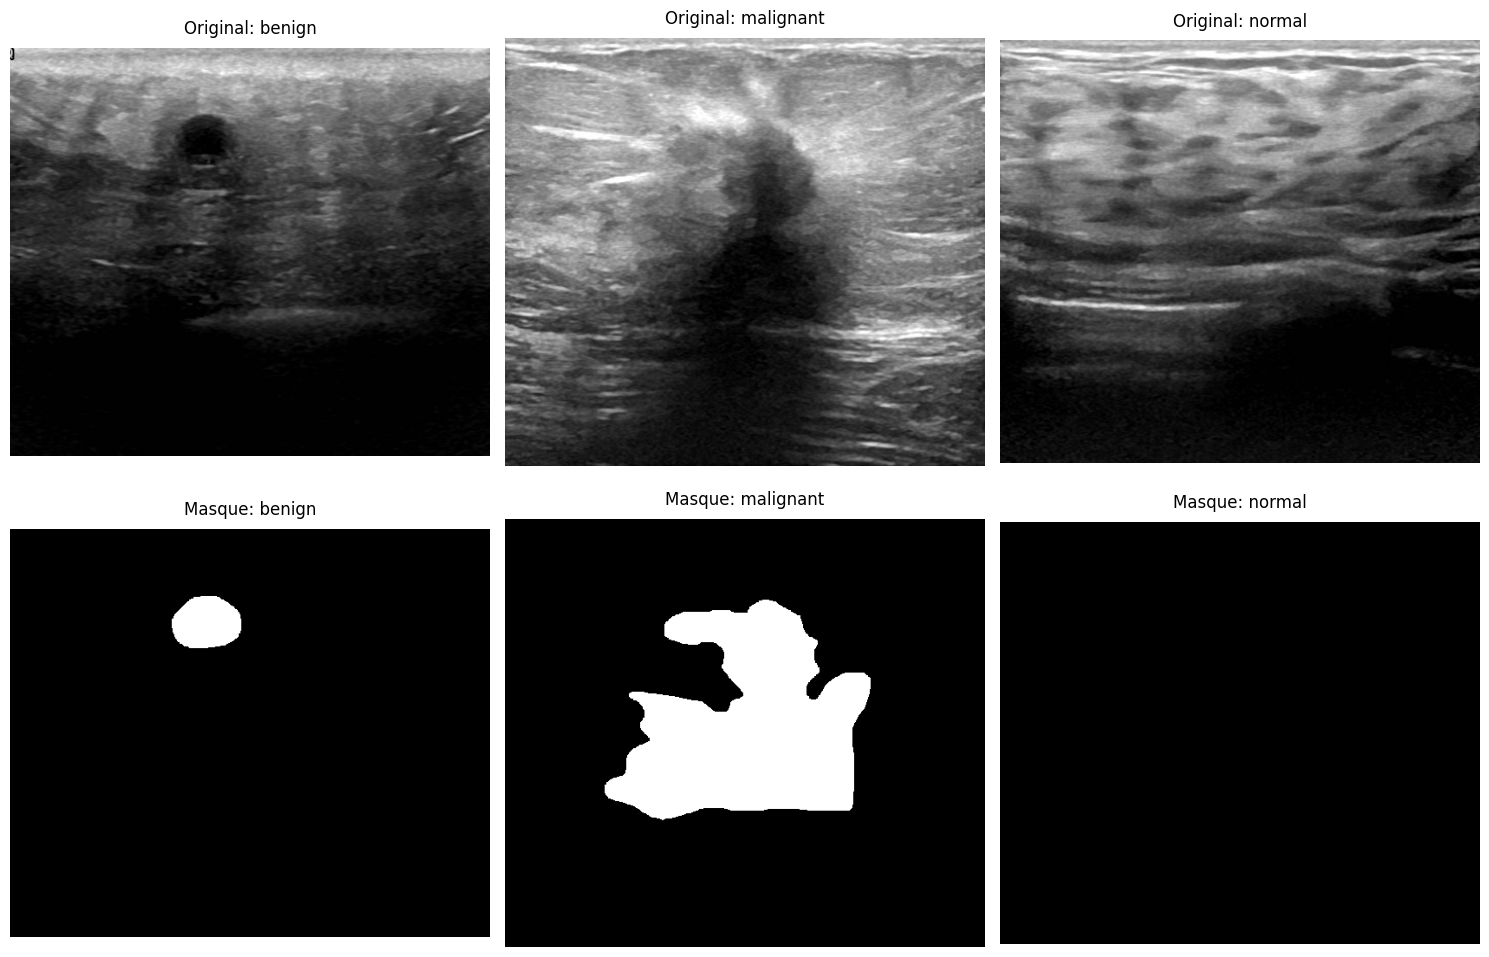

In [20]:
# Affichage d'un échantillon
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA'] # Définir les couleurs

plt.figure(figsize=(15, 8))
plt.suptitle("Échantillon d'une image originale et son masque dans chaque catégorie", 
             size=18, fontweight='bold',
             fontname='monospace', color="#1F1F1F", y=1.02)

# Nous affichons 3 images venant des catégories et leurs masques
num_categories = 3
fig, axes = plt.subplots(2, num_categories, figsize=(15, 10))

# Boucle pour itérer chaque catégorie
for i in range(num_categories):
    # Trouver la première image des données d'entraînement
    for j in range(len(y_train)):
        if y_train[j] == i:
            # Charger l'image et son masque
            original_img = cv2.imread(X_train[j])
            original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
            mask_img = cv2.imread(masked_train[j], cv2.IMREAD_GRAYSCALE)
            
            # Afficher l'image original au premier rang
            axes[0, i].imshow(original_img)
            axes[0, i].set_title(f"Original: {categories[i]}", pad=10)
            axes[0, i].axis('off')
            
            # Afficher le masque au second rang
            axes[1, i].imshow(mask_img, cmap='gray')
            axes[1, i].set_title(f"Masque: {categories[i]}", pad=10)
            axes[1, i].axis('off')
            break

plt.tight_layout()

In [21]:
# Quantifier la distribution des régions atteintes de tumeurs (en utilisant les pixels blancs des masques)
mask_pixel_counts = []
for mask_path in mask_paths:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_pixel_counts.append(np.sum(mask > 0))  # Compter les pixels blancs

# Ajouter au DataFrame
df = pd.DataFrame({
    'Catégorie': [categories[l] for l in labels],
    'mask_pixels': mask_pixel_counts
})

# Group by 'Catégorie'
print("\nStatisques sur les images masqués (Région atteint par la tumeur):")
print(df.groupby('Catégorie').describe())


Statisques sur les images masqués (Région atteint par la tumeur):
          mask_pixels                                                        \
                count          mean           std    min       25%      50%   
Catégorie                                                                     
benign          437.0  20734.208238  28769.735793  804.0   4425.00  10263.0   
malignant       210.0  43376.852381  33076.910545  569.0  18006.25  34433.0   
normal          133.0      0.000000      0.000000    0.0      0.00      0.0   

                               
                75%       max  
Catégorie                      
benign     25108.00  209121.0  
malignant  57937.25  167411.0  
normal         0.00       0.0  


# Transformation des données
Création d'une classe pour transformer les données

In [22]:
# ===================================================================
# Classe d'assistance pour transformer les données --> ImageTransform
# ===================================================================
class ImageTransform:
    def __init__(self, image_transform, masked_transform):
        self.image_transform = image_transform
        self.masked_transform = masked_transform

    # Transformer les images et masques (en évitant l'utilisation de if-statements)
    def __call__(self, image, mask):
        return self.image_transform(image), self.masked_transform(mask)


# Transformation des images originales
image_training_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.RandomCrop(224), # Augmenter l'image avec random crop
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # Statistiques de ImageNet
])

# Transformation des images de validation ***À MODIFIER (C'EST LA MÊME QUE image_training_transform)
image_val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) 
])

# Transformation des images masqués (aucune normalisation)
masked_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Classe pour la base de données

In [23]:
# ==================================================================================
# Classe pour gérer la base de données d'images échographiques --> UltrasoundDataset
# ==================================================================================
class UltrasoundDataset(Dataset):
    def __init__(self, image_paths, masked_paths, labels, transform = None):
        self.image_paths = image_paths
        self.masked_paths = masked_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = cv2.cvtColor(cv2.imread(self.image_paths[index]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masked_paths[index], cv2.IMREAD_GRAYSCALE)
        label = self.labels[index]
        
        if self.transform:
            image, mask = self.transform(image, mask)

        # Calculer la superficie de la tumeur
        region_tumeur = torch.tensor([torch.sum(mask > 0).item() / (224*224)])

        return {
            'image': image,
            'masque': mask,
            'superficie_tumeur' : region_tumeur,
            'categorie' : torch.tensor(label, dtype = torch.long)
        }
        
# Données d'entraînement
training_dataset = UltrasoundDataset(
    X_train, 
    masked_train, 
    y_train, 
    transform = 
        ImageTransform(
            image_training_transform, 
            masked_transform
        ))

# Données de validation
val_dataset = UltrasoundDataset(
    X_test, 
    masked_test, 
    y_test,
    transform = 
        ImageTransform(
            image_val_transform, 
            masked_transform
        ))

# Création du modèle de machine learning

In [24]:
# ================================================================
# Classe de l'architecture du modèle CNN --> BreastUltrasoundModel
# ================================================================
class BreastUltrasoundModel(nn.Module):
    def __init__(self, num_classes = 3):
        super().__init__()
        
        # Images originales
        self.backbone = models.resnet18(pretrained=True)
        num_features = self.backbone.fc.in_features
        
        # Images masquées
        self.mask_branch = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Région appartenant à la tumeur
        self.area_fc = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU()
        )
        
        # Classifier combinés
        self.classifier = nn.Sequential(
            nn.Linear(num_features + 64*56*56 + 32, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, mask, region_tumeur):
        # Images
        img_features = self.backbone.conv1(x)
        img_features = self.backbone.bn1(img_features)
        img_features = self.backbone.relu(img_features)
        img_features = self.backbone.maxpool(img_features)
        img_features = self.backbone.layer1(img_features)
        img_features = self.backbone.layer2(img_features)
        img_features = self.backbone.layer3(img_features)
        img_features = self.backbone.layer4(img_features)
        img_features = self.backbone.avgpool(img_features)
        img_features = torch.flatten(img_features, 1)

        # Masques
        mask_features = self.mask_branch(mask)
        mask_features = torch.flatten(mask_features, 1)

        # Superficies de la tumeur
        superficie_features = self.area_fc(region_tumeur)

        # Features précédents combinés
        combined = torch.cat([img_features, mask_features, superficie_features], dim=1)
        return self.classifier(combined)

    def loss(self, outputs, targets):
        pass


# Setup et boucle d'entraînement du modèle

In [25]:
# ===================================
# Poids des catégories non-équilibrés
# ===================================
categorie_counts = Counter(y_train)
total = sum(categorie_counts.values())
categorie_weights = torch.tensor([total/categorie_counts[i] for i in range(3)], dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BreastUltrasoundModel().to(device)
criterion = nn.CrossEntropyLoss(weight=categorie_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

# Data loaders
train_loader = DataLoader(training_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
# ======
# Boucle
# ======
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch in loader:
        images = batch['image'].to(device)
        masks = batch['masque'].to(device)
        areas = batch['superficie_tumeur'].to(device)
        labels = batch['categorie'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images, masks, areas)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss/len(loader), correct/total

# Évaluation

In [27]:
# ====================
# Évaluation du modèle
# ====================
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            masks = batch['masque'].to(device)
            areas = batch['superficie_tumeur'].to(device)
            labels = batch['categorie'].to(device)
            
            outputs = model(images, masks, areas)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Rapport de classification
    print("\nRapport de classification:")
    print(classification_report(all_labels, all_preds, target_names=categories))
    
    # Matrice de confusion
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=categories, yticklabels=categories)
    plt.title("Matrice de confusion")
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.show()
    
    return running_loss/len(loader), correct/total

# Éxecuter l'entraînement


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.74      0.85      0.79        87
   malignant       0.62      0.38      0.47        42
      normal       0.90      1.00      0.95        27

    accuracy                           0.75       156
   macro avg       0.75      0.74      0.74       156
weighted avg       0.73      0.75      0.73       156



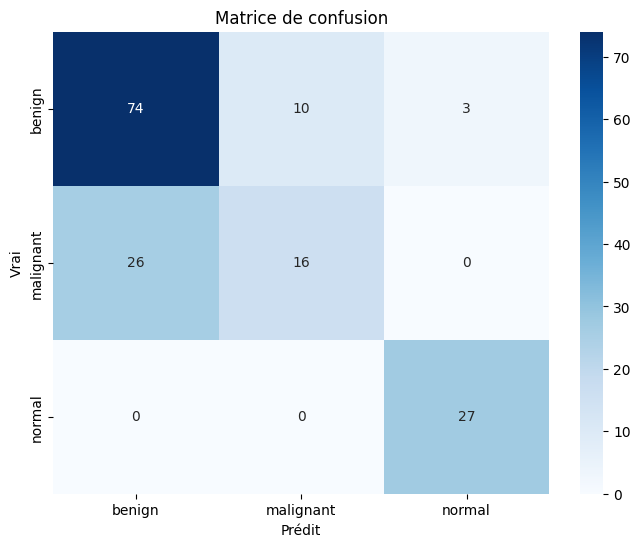

Epoch 1:
Train Loss: 24.7860 | Train Acc: 55.29%
Val Loss: 7.6024 | Val Acc: 75.00%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.89      0.64      0.75        87
   malignant       0.56      0.83      0.67        42
      normal       0.87      1.00      0.93        27

    accuracy                           0.76       156
   macro avg       0.77      0.83      0.78       156
weighted avg       0.80      0.76      0.76       156



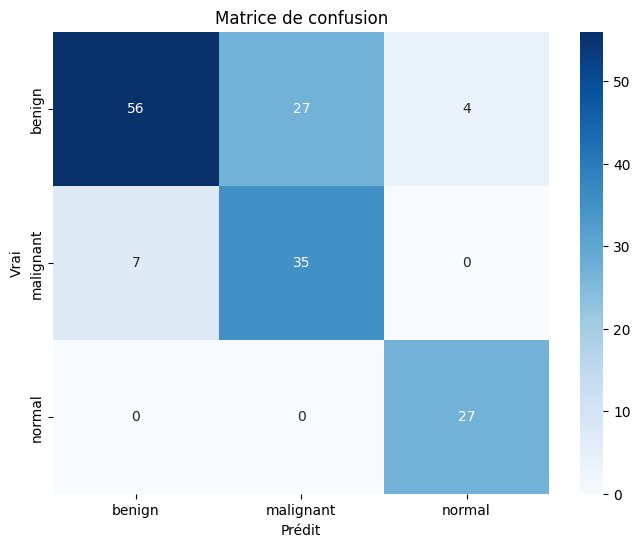

Epoch 2:
Train Loss: 7.5813 | Train Acc: 64.26%
Val Loss: 4.0888 | Val Acc: 75.64%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.83      0.63      0.72        87
   malignant       0.50      0.74      0.60        42
      normal       0.96      1.00      0.98        27

    accuracy                           0.72       156
   macro avg       0.77      0.79      0.77       156
weighted avg       0.77      0.72      0.73       156



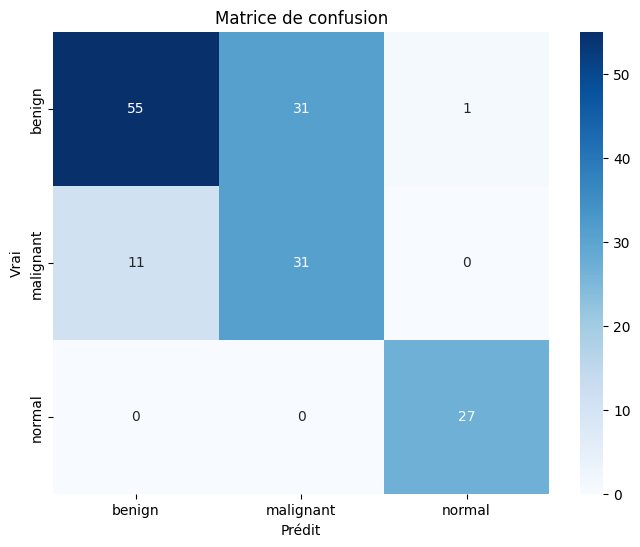

Epoch 3:
Train Loss: 2.2173 | Train Acc: 69.55%
Val Loss: 0.8757 | Val Acc: 72.44%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.84      0.70      0.76        87
   malignant       0.61      0.71      0.66        42
      normal       0.79      1.00      0.89        27

    accuracy                           0.76       156
   macro avg       0.75      0.81      0.77       156
weighted avg       0.77      0.76      0.76       156



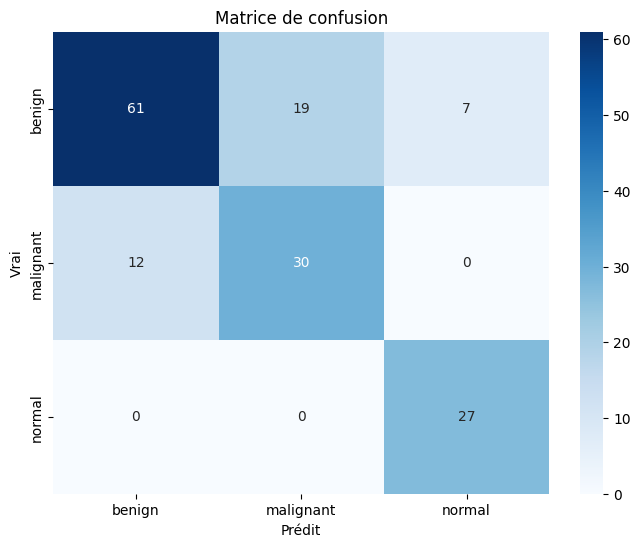

Epoch 4:
Train Loss: 0.7984 | Train Acc: 77.72%
Val Loss: 0.6650 | Val Acc: 75.64%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.81      0.64      0.72        87
   malignant       0.52      0.69      0.59        42
      normal       0.87      1.00      0.93        27

    accuracy                           0.72       156
   macro avg       0.73      0.78      0.75       156
weighted avg       0.74      0.72      0.72       156



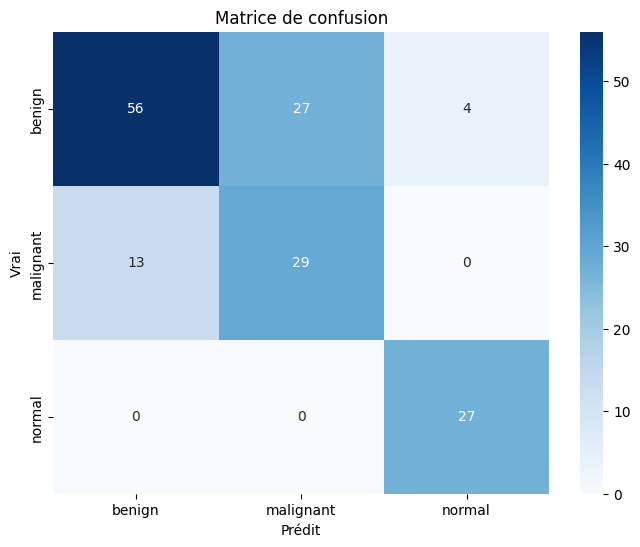

Epoch 5:
Train Loss: 0.5398 | Train Acc: 77.24%
Val Loss: 0.5601 | Val Acc: 71.79%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.78      0.92      0.84        87
   malignant       0.73      0.45      0.56        42
      normal       1.00      1.00      1.00        27

    accuracy                           0.81       156
   macro avg       0.84      0.79      0.80       156
weighted avg       0.80      0.81      0.79       156



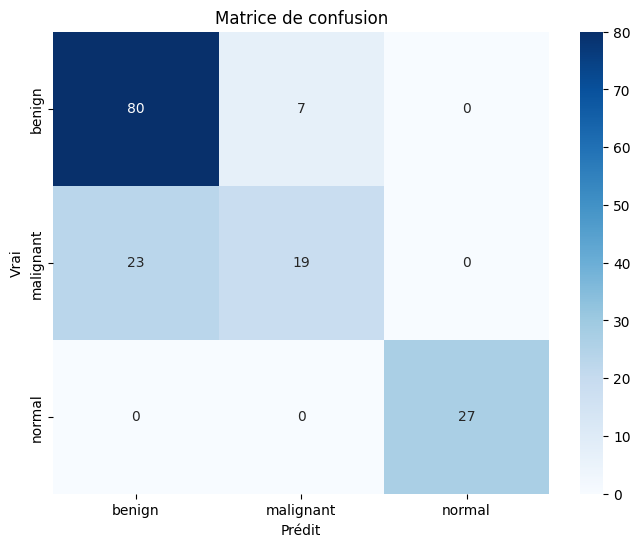

Epoch 6:
Train Loss: 0.3283 | Train Acc: 83.33%
Val Loss: 0.6235 | Val Acc: 80.77%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.82      0.72      0.77        87
   malignant       0.63      0.64      0.64        42
      normal       0.75      1.00      0.86        27

    accuracy                           0.75       156
   macro avg       0.73      0.79      0.75       156
weighted avg       0.76      0.75      0.75       156



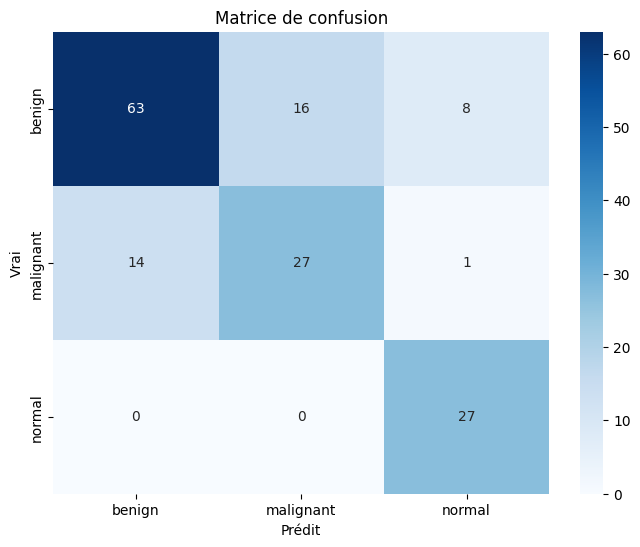

Epoch 7:
Train Loss: 0.2816 | Train Acc: 85.26%
Val Loss: 0.6449 | Val Acc: 75.00%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.84      0.70      0.76        87
   malignant       0.57      0.71      0.63        42
      normal       0.90      1.00      0.95        27

    accuracy                           0.76       156
   macro avg       0.77      0.81      0.78       156
weighted avg       0.77      0.76      0.76       156



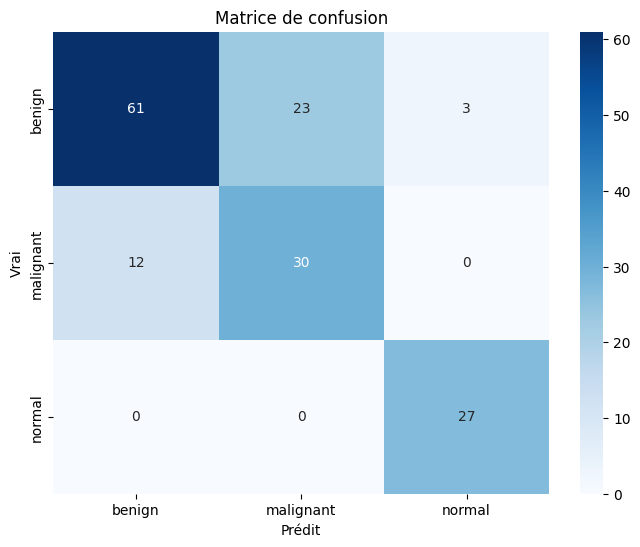

Epoch 8:
Train Loss: 0.2957 | Train Acc: 87.98%
Val Loss: 0.5666 | Val Acc: 75.64%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.84      0.82      0.83        87
   malignant       0.67      0.67      0.67        42
      normal       0.93      1.00      0.96        27

    accuracy                           0.81       156
   macro avg       0.81      0.83      0.82       156
weighted avg       0.81      0.81      0.81       156



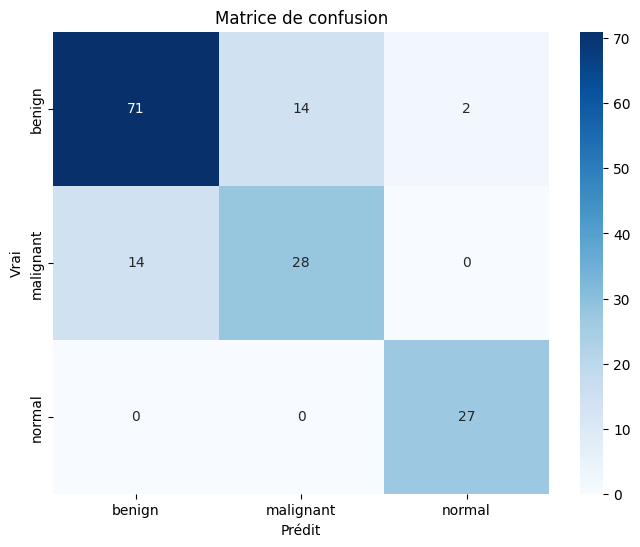

Epoch 9:
Train Loss: 0.2470 | Train Acc: 88.30%
Val Loss: 0.5295 | Val Acc: 80.77%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.80      0.72      0.76        87
   malignant       0.68      0.60      0.63        42
      normal       0.68      1.00      0.81        27

    accuracy                           0.74       156
   macro avg       0.72      0.77      0.73       156
weighted avg       0.74      0.74      0.73       156



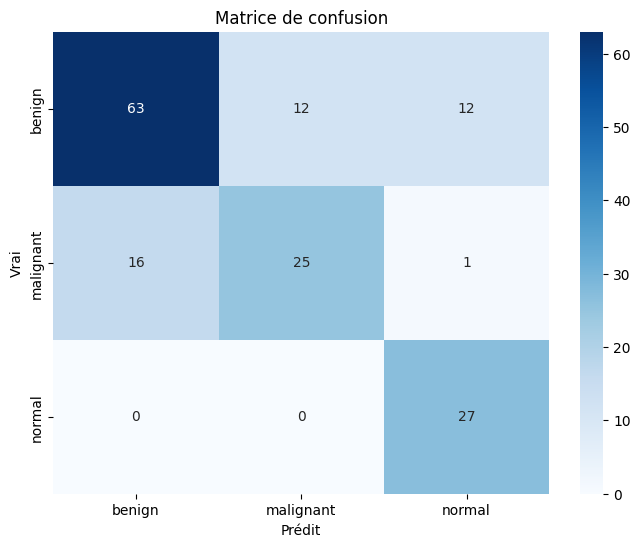

Epoch 10:
Train Loss: 0.2222 | Train Acc: 89.42%
Val Loss: 0.7535 | Val Acc: 73.72%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.80      0.79      0.80        87
   malignant       0.66      0.60      0.62        42
      normal       0.84      1.00      0.92        27

    accuracy                           0.78       156
   macro avg       0.77      0.80      0.78       156
weighted avg       0.77      0.78      0.77       156



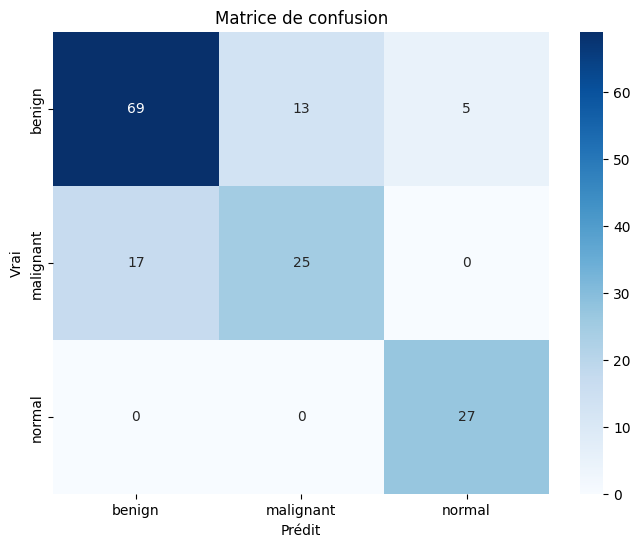

Epoch 11:
Train Loss: 0.2069 | Train Acc: 91.19%
Val Loss: 0.7641 | Val Acc: 77.56%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.79      0.82      0.80        87
   malignant       0.61      0.55      0.57        42
      normal       0.96      1.00      0.98        27

    accuracy                           0.78       156
   macro avg       0.79      0.79      0.79       156
weighted avg       0.77      0.78      0.77       156



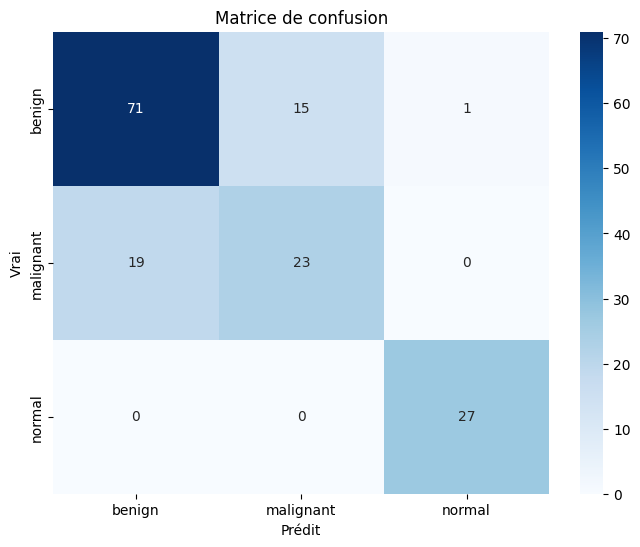

Epoch 12:
Train Loss: 0.1649 | Train Acc: 92.95%
Val Loss: 0.9518 | Val Acc: 77.56%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.75      0.84      0.79        87
   malignant       0.58      0.43      0.49        42
      normal       0.96      1.00      0.98        27

    accuracy                           0.76       156
   macro avg       0.77      0.76      0.76       156
weighted avg       0.74      0.76      0.75       156



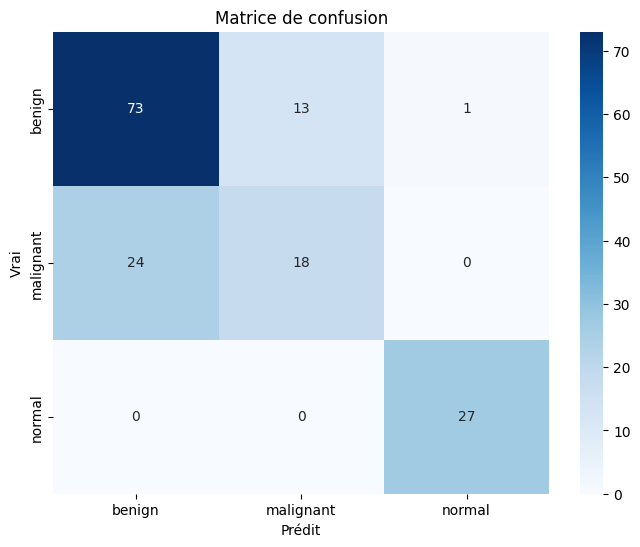

Epoch 13:
Train Loss: 0.1825 | Train Acc: 92.63%
Val Loss: 0.7759 | Val Acc: 75.64%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.76      0.82      0.79        87
   malignant       0.57      0.48      0.52        42
      normal       0.96      1.00      0.98        27

    accuracy                           0.76       156
   macro avg       0.77      0.76      0.76       156
weighted avg       0.75      0.76      0.75       156



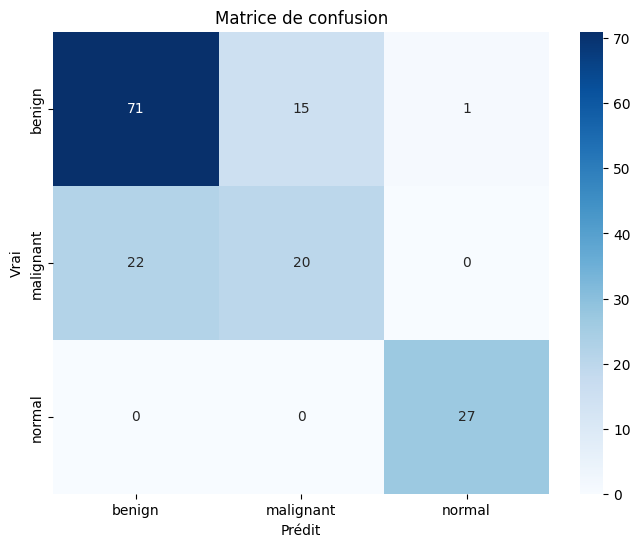

Epoch 14:
Train Loss: 0.1402 | Train Acc: 92.47%
Val Loss: 0.6579 | Val Acc: 75.64%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.79      0.82      0.80        87
   malignant       0.61      0.55      0.57        42
      normal       0.96      1.00      0.98        27

    accuracy                           0.78       156
   macro avg       0.79      0.79      0.79       156
weighted avg       0.77      0.78      0.77       156



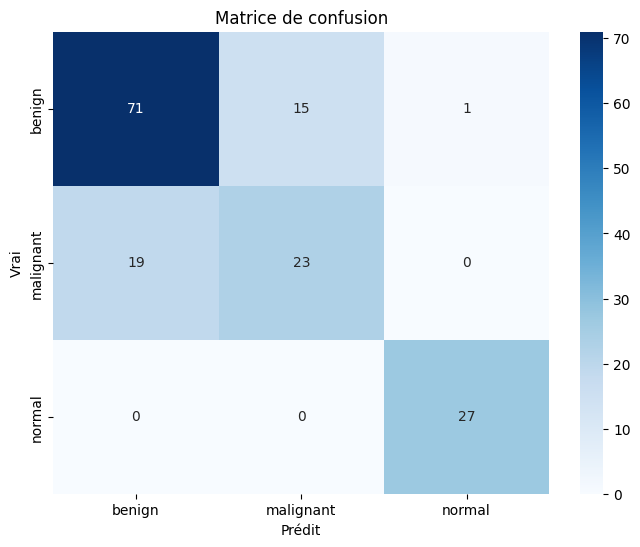

Epoch 15:
Train Loss: 0.1002 | Train Acc: 95.83%
Val Loss: 0.6537 | Val Acc: 77.56%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.80      0.83      0.81        87
   malignant       0.63      0.57      0.60        42
      normal       0.96      1.00      0.98        27

    accuracy                           0.79       156
   macro avg       0.80      0.80      0.80       156
weighted avg       0.78      0.79      0.79       156



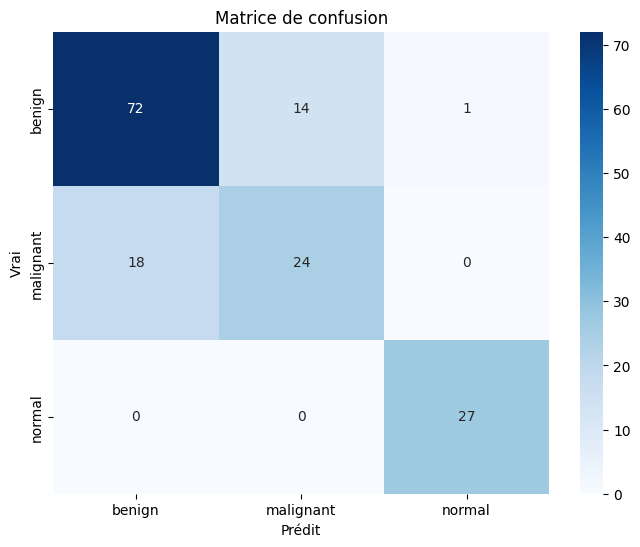

Epoch 16:
Train Loss: 0.1053 | Train Acc: 95.67%
Val Loss: 0.6608 | Val Acc: 78.85%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.80      0.84      0.82        87
   malignant       0.65      0.57      0.61        42
      normal       0.96      1.00      0.98        27

    accuracy                           0.79       156
   macro avg       0.81      0.80      0.80       156
weighted avg       0.79      0.79      0.79       156



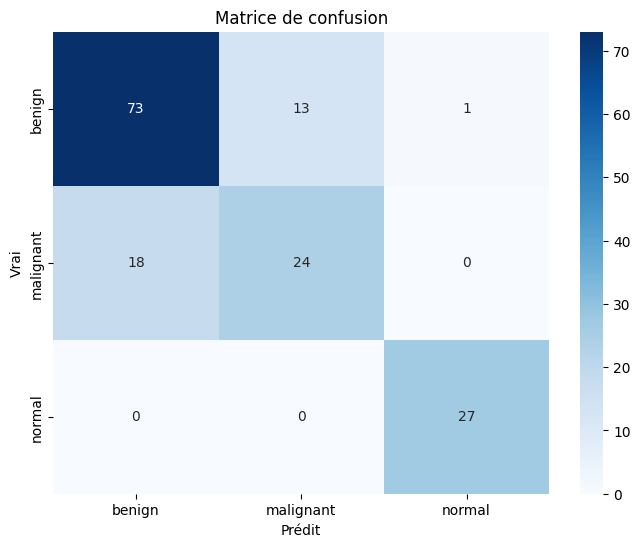

Epoch 17:
Train Loss: 0.0966 | Train Acc: 95.67%
Val Loss: 0.6323 | Val Acc: 79.49%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.79      0.84      0.82        87
   malignant       0.64      0.55      0.59        42
      normal       0.96      1.00      0.98        27

    accuracy                           0.79       156
   macro avg       0.80      0.80      0.80       156
weighted avg       0.78      0.79      0.78       156



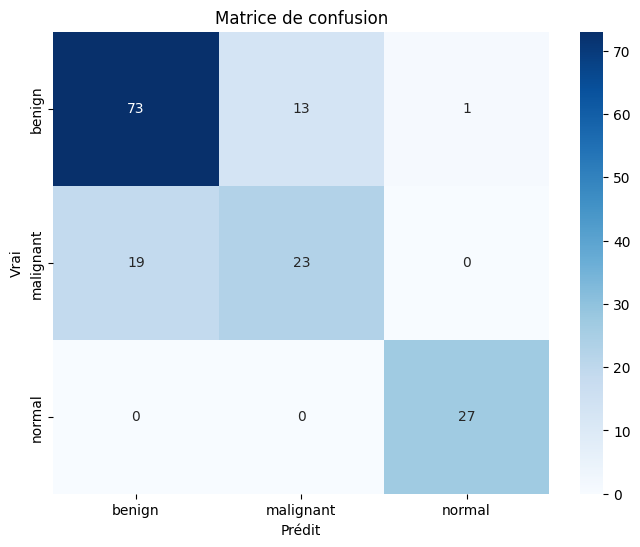

Epoch 18:
Train Loss: 0.0846 | Train Acc: 95.99%
Val Loss: 0.6270 | Val Acc: 78.85%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.82      0.83      0.82        87
   malignant       0.65      0.62      0.63        42
      normal       0.96      1.00      0.98        27

    accuracy                           0.80       156
   macro avg       0.81      0.82      0.81       156
weighted avg       0.80      0.80      0.80       156



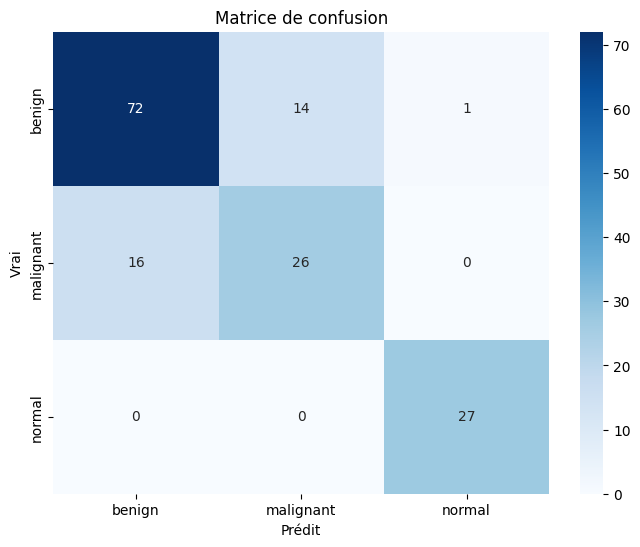

Epoch 19:
Train Loss: 0.0853 | Train Acc: 97.12%
Val Loss: 0.6544 | Val Acc: 80.13%


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.81      0.83      0.82        87
   malignant       0.64      0.60      0.62        42
      normal       0.96      1.00      0.98        27

    accuracy                           0.79       156
   macro avg       0.80      0.81      0.81       156
weighted avg       0.79      0.79      0.79       156



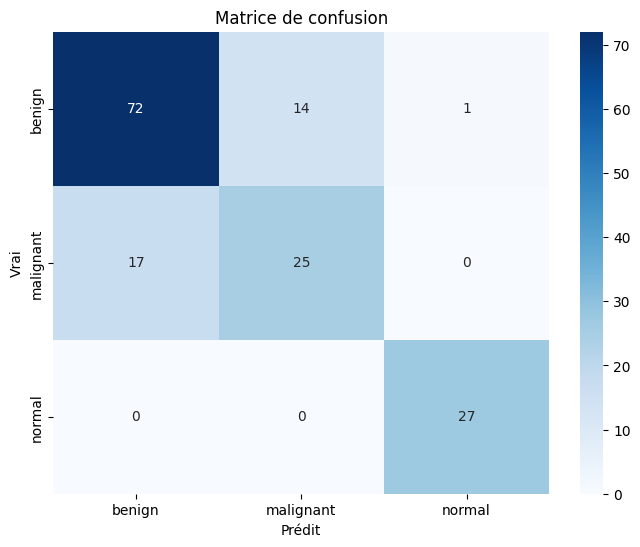

Epoch 20:
Train Loss: 0.0759 | Train Acc: 97.44%
Val Loss: 0.6474 | Val Acc: 79.49%



In [28]:
# =======================
# Éxecuter l'entraînement
# =======================
for epoch in range(20):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, test_loader, criterion)
    
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}\n")

# Évaluation du modèle avancé

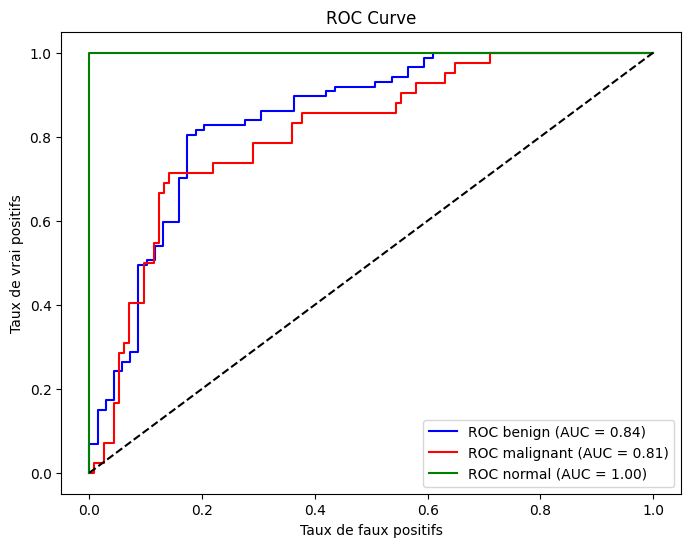

In [29]:
# ===========================
# Évaluation du modèle avancé
# ===========================
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(model, loader):
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            masks = batch['masque'].to(device)
            areas = batch['superficie_tumeur'].to(device)
            labels = batch['categorie'].to(device)
            
            outputs = model(images, masks, areas)
            probs = torch.softmax(outputs, dim=1)
            
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Binarize labels for ROC
    y_true = label_binarize(all_labels, classes=[0,1,2])
    y_score = np.array(all_probs)
    
    # Compute ROC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot
    plt.figure(figsize=(8,6))
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'ROC {categories[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrai positifs')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

plot_roc_curve(model, test_loader)